# II-4 Analyse Multi-variable (ACP / PCA)

**But:** analyser l'information conjointe entre variables, appliquer l'ACP (PCA) et interpréter les composantes principales.


In [2]:

import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import AgglomerativeClustering
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

DATA_PATH = '../../data/raw/diabetes.csv'

if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    print(f'Loaded dataset from {DATA_PATH} with shape', df.shape)
else:
    print(f'{DATA_PATH} not found — création d\'un jeu de données synthétique (exemple).')
    
df.head()


Loaded dataset from ../../data/raw/diabetes.csv with shape (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Observations n=768, variables p=8, n/p=96.00

Correlation matrix (post-standardization, should be same as before):
                           Pregnancies  Glucose  BloodPressure  SkinThickness  \
Pregnancies                     1.000    0.129          0.141         -0.082   
Glucose                         0.129    1.000          0.153          0.057   
BloodPressure                   0.141    0.153          1.000          0.207   
SkinThickness                  -0.082    0.057          0.207          1.000   
Insulin                        -0.074    0.331          0.089          0.437   
BMI                             0.018    0.221          0.282          0.393   
DiabetesPedigreeFunction       -0.034    0.137          0.041          0.184   
Age                             0.544    0.264          0.240         -0.114   

                          Insulin    BMI  DiabetesPedigreeFunction    Age  
Pregnancies                -0.074  0.018                    -0.034  0.544  
Glucose    

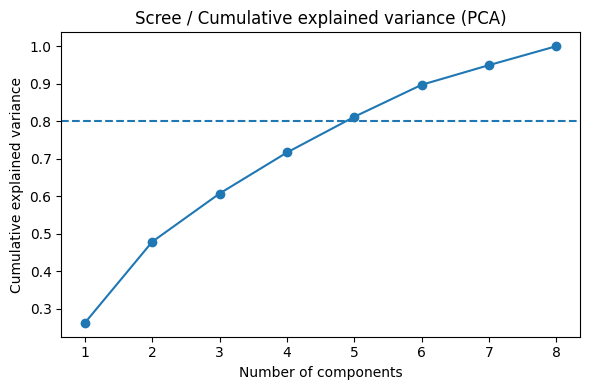


Explained by first 2 PCs: 0.4781987607385657


In [3]:

# 1) Vérifier les conditions : standardisation, corrélations, ratio n/p
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

numeric = df.select_dtypes(include=[np.number]).drop(columns=['Outcome'])
p, n = numeric.shape[1], numeric.shape[0]
print(f'Observations n={n}, variables p={p}, n/p={n/p:.2f}')

# Standardisation
scaler = StandardScaler()
Xs = scaler.fit_transform(numeric)
# Vérifier la matrice de corrélation
corr_num = pd.DataFrame(Xs, columns=numeric.columns).corr()
print('\nCorrelation matrix (post-standardization, should be same as before):\n', corr_num.round(3))

# 2) Appliquer PCA
pca = PCA()
pca.fit(Xs)
explained = pca.explained_variance_ratio_
cumulative = explained.cumsum()
for i,(e,cum) in enumerate(zip(explained, cumulative), start=1):
    print(f'PC{i}: variance explained = {e:.4f}, cumulative = {cum:.4f}')

# Plot cumulative variance
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumulative)+1), cumulative, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Scree / Cumulative explained variance (PCA)')
plt.axhline(0.8, linestyle='--')
plt.tight_layout()
plt.show()

# 3) If first 2 PCs explain >= 0.80, good; otherwise consider more components
print('\nExplained by first 2 PCs:', cumulative[1])


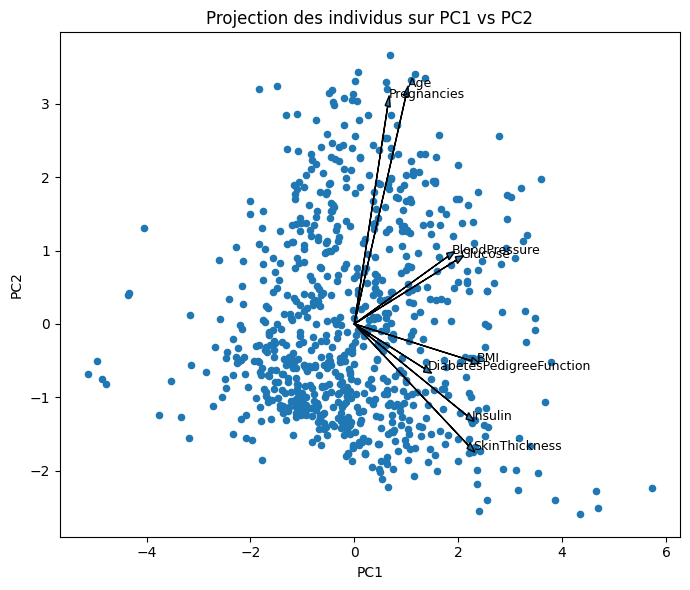

,PC1,PC2,PC3,PC4
Pregnancies,0.128,0.594,0.013,0.081
Glucose,0.393,0.174,-0.468,-0.404
BloodPressure,0.360,0.184,0.535,0.056
SkinThickness,0.440,-0.332,0.238,0.038
Insulin,0.435,-0.251,-0.337,-0.350
BMI,0.452,-0.101,0.362,0.054
DiabetesPedigreeFunction,0.271,-0.122,-0.433,0.834
Age,0.198,0.621,-0.075,0.071


In [4]:

# 4) Biplot / projection des individus et des variables sur les deux premières composantes
# We'll create a simple biplot: scatter of PC1 vs PC2 and arrows for loadings
components = pca.components_
pc_scores = pca.transform(Xs)  # coordinates of individuals

pc1 = pc_scores[:,0]
pc2 = pc_scores[:,1]

plt.figure(figsize=(7,6))
plt.scatter(pc1, pc2, s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection des individus sur PC1 vs PC2')

# Plot variable loadings as arrows
loadings = components[:2].T  # shape p x 2
for i, var in enumerate(numeric.columns):
    plt.arrow(0,0, loadings[i,0]*5, loadings[i,1]*5, head_width=0.1)
    plt.text(loadings[i,0]*5.2, loadings[i,1]*5.2, var, fontsize=9)
plt.tight_layout()
plt.show()

# 5) Interpréter: lister les variables avec plus grande contribution aux PC1/PC2
loading_df = pd.DataFrame(components.T, index=numeric.columns, columns=[f'PC{i}' for i in range(1, components.shape[0]+1)])
display(loading_df.iloc[:,:4].round(3))


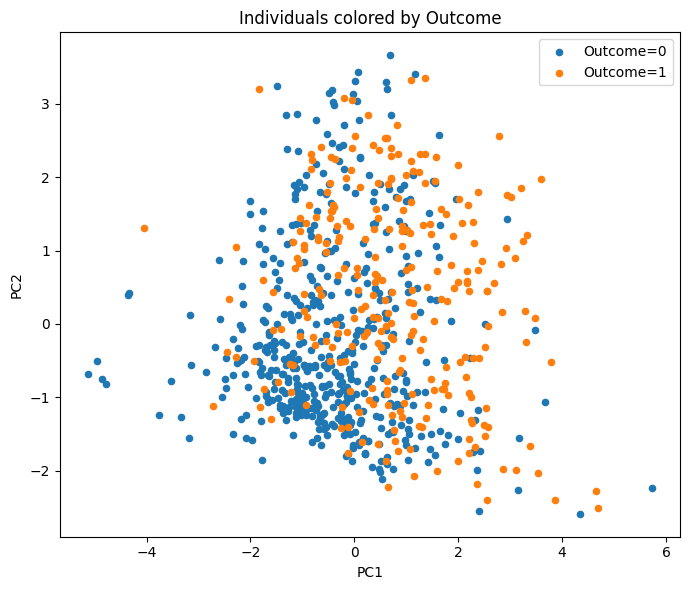

Variance explained by first 3 PCs: 0.6069024943865848


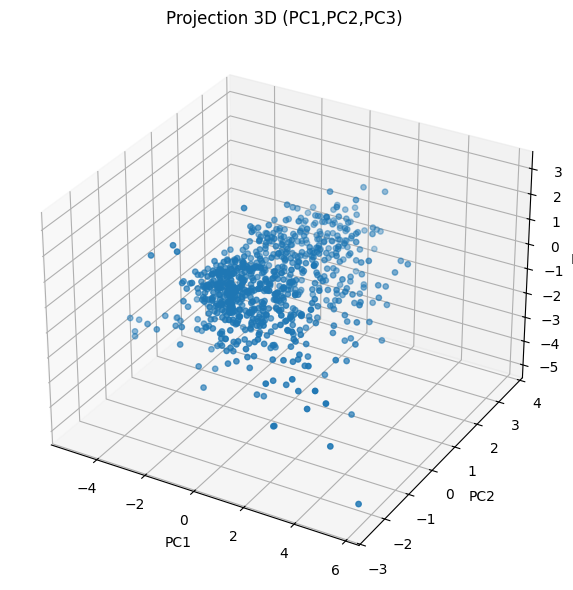

In [5]:

# 6) Analyse des individus projetés: détecter groupes, outliers dans l'espace PC
# Example: plot Outcome labels if available
if 'Outcome' in df.columns:
    plt.figure(figsize=(7,6))
    for label in sorted(df['Outcome'].unique()):
        mask = df['Outcome']==label
        plt.scatter(pc1[mask], pc2[mask], s=20, label=f'Outcome={label}')
    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.title('Individuals colored by Outcome'); plt.tight_layout(); plt.show()

# 7) Si la variance expliquée par 2 premiers PC < 0.8, inspecter 3ème composante
if cumulative[1] < 0.8 and Xs.shape[1] >= 3:
    print('Variance explained by first 3 PCs:', cumulative[2])
    # simple 3D scatter (matplotlib)
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc_scores[:,0], pc_scores[:,1], pc_scores[:,2], s=15)
    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
    plt.title('Projection 3D (PC1,PC2,PC3)')
    plt.tight_layout()
    plt.show()
